In [1]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import sys
print(sys.executable)

C:\Users\Disha Sharma\.conda\envs\analytics\python.exe


In [9]:
import sys
!"{sys.executable}" -m pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   ----------------- ---------------------- 4.2/9.6 MB 19.3 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 22.1 MB/s  0:00:00

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- --

In [50]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

df = pd.read_csv(r"C:\Users\Disha Sharma\Desktop\XAI\bike-sharing-dataset\day.csv")

print(df.columns)
print(df.head())

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0

In [52]:
df = df[['cnt', 'season', 'holiday', 'workingday',
         'weathersit', 'temp', 'hum', 'windspeed']]

In [54]:
# Map season
df['season'] = df['season'].map({
    1: 'SPRING',
    2: 'SUMMER',
    3: 'FALL',
    4: 'WINTER'
})

# Map weather
df['weathersit'] = df['weathersit'].map({
    1: 'GOOD',
    2: 'MISTY',
    3: 'BAD'
})

In [56]:
df.rename(columns={
    'workingday': 'workday',
    'weathersit': 'weather'
}, inplace=True)

In [58]:
df['cnt_2d_bfr'] = df['cnt'].shift(2)

In [60]:
df = df.dropna()

In [62]:
df = df[df['hum'] != 0]

In [64]:
df = pd.get_dummies(
    df,
    columns=['season', 'weather'],
    drop_first=True
)

In [66]:
print(df.dtypes)

cnt                int64
holiday            int64
workday            int64
temp             float64
hum              float64
windspeed        float64
cnt_2d_bfr       float64
season_SPRING       bool
season_SUMMER       bool
season_WINTER       bool
weather_GOOD        bool
weather_MISTY       bool
dtype: object


In [68]:
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

In [70]:
print(df.dtypes)

cnt                int64
holiday            int64
workday            int64
temp             float64
hum              float64
windspeed        float64
cnt_2d_bfr       float64
season_SPRING      int32
season_SUMMER      int32
season_WINTER      int32
weather_GOOD       int32
weather_MISTY      int32
dtype: object


In [72]:
y = df['cnt']
X = df.drop(columns=['cnt'])

X = sm.add_constant(X)

In [74]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     202.1
Date:                Sun, 22 Feb 2026   Prob (F-statistic):          4.52e-211
Time:                        17:52:18   Log-Likelihood:                -6024.6
No. Observations:                 728   AIC:                         1.207e+04
Df Residuals:                     716   BIC:                         1.213e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           181.6250    471.237      0.385

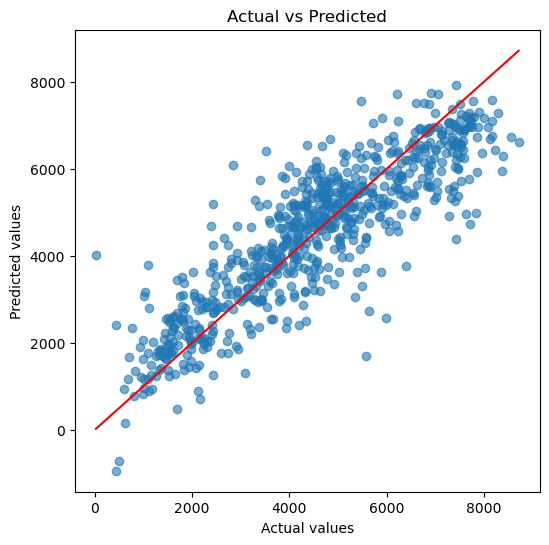

In [85]:
import matplotlib.pyplot as plt

y_pred = model.predict(X)

plt.figure(figsize=(6,6))
plt.scatter(y, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()],
         [y.min(), y.max()],
         color='red')

plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted")
plt.show()

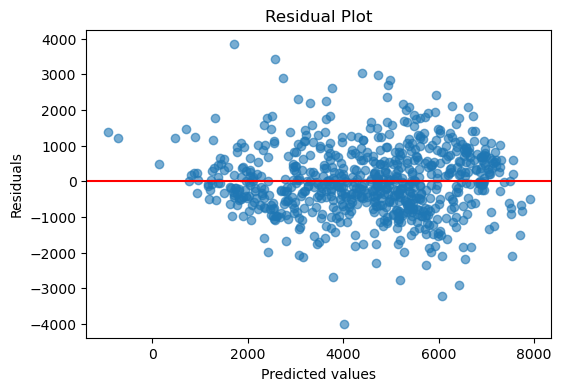

In [87]:
residuals = y - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red')

plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

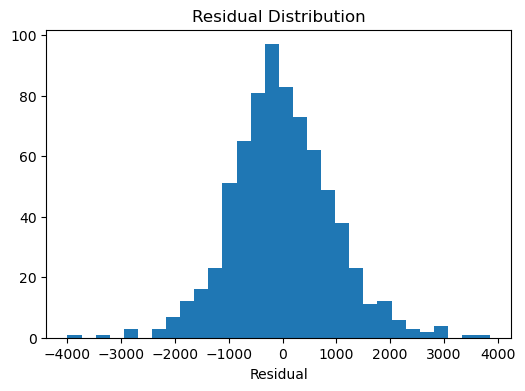

In [89]:
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.show()

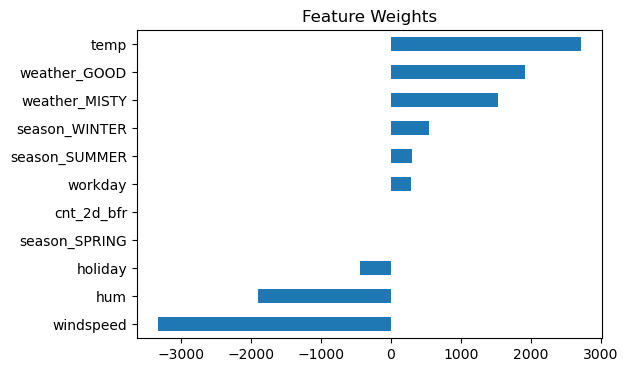

In [91]:
coef = model.params.drop('const')

plt.figure(figsize=(6,4))
coef.sort_values().plot(kind='barh')
plt.title("Feature Weights")
plt.show()

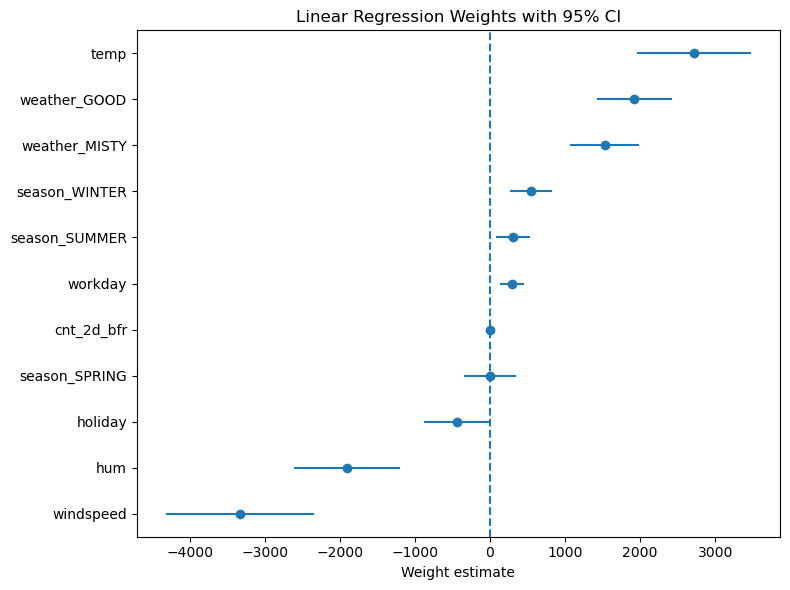

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Get coefficients
coef = model.params
conf = model.conf_int()
conf.columns = ['lower', 'upper']

# Remove intercept for plotting
coef = coef.drop('const')
conf = conf.drop('const')

# Sort by coefficient value
coef = coef.sort_values()
conf = conf.loc[coef.index]

# Plot
plt.figure(figsize=(8,6))
plt.errorbar(
    coef.values,
    coef.index,
    xerr=[coef.values - conf['lower'],
          conf['upper'] - coef.values],
    fmt='o'
)

plt.axvline(0, linestyle='--')
plt.xlabel("Weight estimate")
plt.title("Linear Regression Weights with 95% CI")
plt.tight_layout()
plt.show()

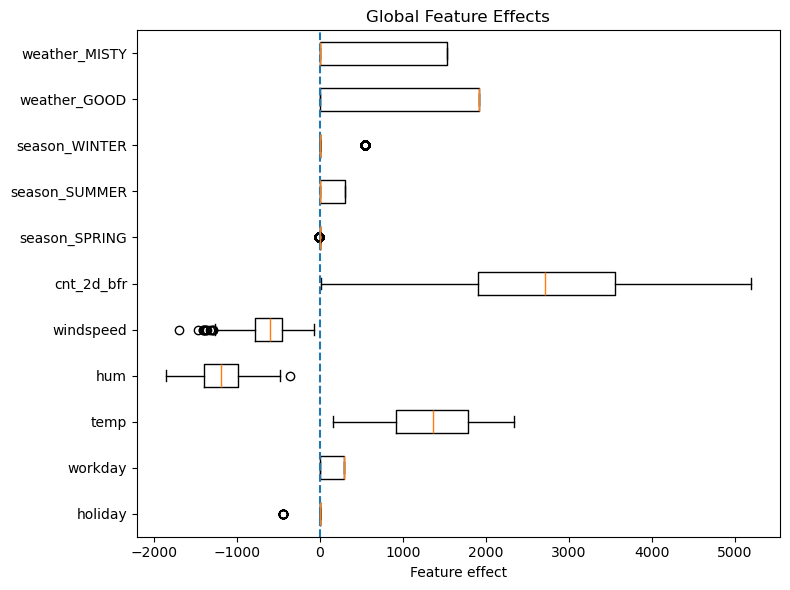

In [79]:
# Compute feature effects
X_no_const = X.drop(columns=['const'])
effects = X_no_const.multiply(model.params.drop('const'), axis=1)

plt.figure(figsize=(8,6))
plt.boxplot(effects.values, vert=False)
plt.yticks(range(1, len(effects.columns)+1), effects.columns)
plt.axvline(0, linestyle='--')
plt.xlabel("Feature effect")
plt.title("Global Feature Effects")
plt.tight_layout()
plt.show()

Predicted value: 1343
Average predicted value: 4520
Actual value: 822


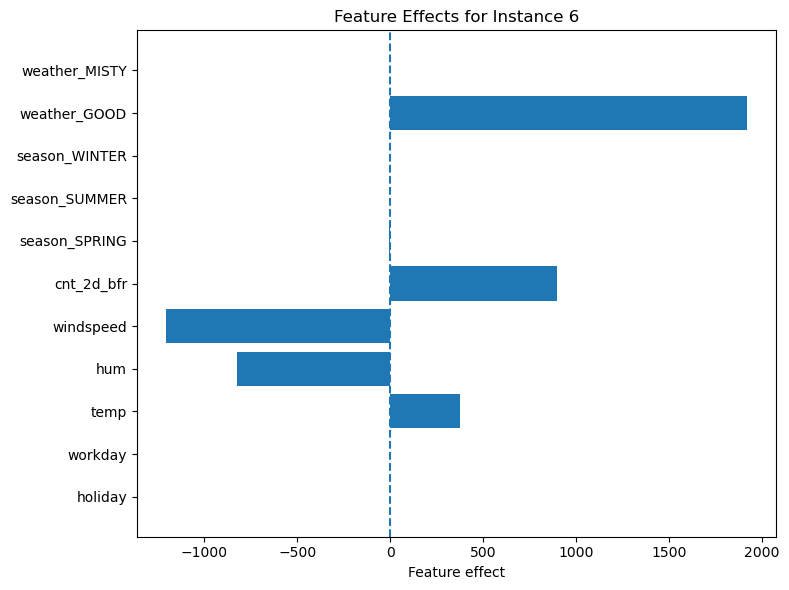

In [83]:
i = 6

instance = X_no_const.iloc[i]
instance_effect = instance * model.params.drop('const')

pred = model.predict(X.iloc[i])
actual = y.iloc[i]

print("Predicted value:", round(pred.iloc[0]))
print("Average predicted value:", round(model.predict(X).mean()))
print("Actual value:", actual)

plt.figure(figsize=(8,6))
plt.barh(instance_effect.index, instance_effect.values)
plt.axvline(0, linestyle='--')
plt.xlabel("Feature effect")
plt.title(f"Feature Effects for Instance {i}")
plt.tight_layout()
plt.show()